### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [2]:
!pip install datasets

UnboundLocalError: local variable 'child' referenced before assignment

In [26]:
# %pip install --upgrade transformers datasets accelerate deepspeed
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import transformers
import datasets
import tensorflow as tf
import transformers
from tqdm import tqdm, trange
from IPython.display import clear_output
import numpy as np

from transformers import BertTokenizer, TFBertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = TFBertModel.from_pretrained("bert-base-cased")

import matplotlib.pyplot as plt
%matplotlib inline

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Repo card metadata block was not found. Setting CardData to empty.




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [161]:
qqp
# 727692 = 84*8663

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 727692
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 80860
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 781930
    })
})

In [5]:
# For each sample in the dataset, there're 2 sentences in it.
print(qqp['train'][0])
print()

# If we tokenize them together, the result would be:
# 'input_ids' is the concatenation of the two sentences
# 'token_type_ids' would 0&1, 0 for the first sentence, 1 for the other
tokenizer(qqp['train'][0]['text1'], qqp['train'][0]['text2'])

{'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}



{'input_ids': [101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136, 102, 5979, 1634, 1104, 3073, 20488, 2116, 1110, 1536, 1111, 1103, 12211, 179, 1233, 6451, 1571, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [6]:
# Pytorch
# model_name = "gchhablani/bert-base-cased-finetuned-qqp"
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertModel.from_pretrained("bert-base-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Tokenize the data

In [5]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [8]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 points)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [8]:
val_set = qqp_preprocessed['validation']
val_set

Dataset({
    features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 80860
})

In [35]:
# Convert data to tf.dataset
# ref: https://huggingface.co/docs/datasets/use_dataset#tokenize-text
tf_dataset = val_set.to_tf_dataset(
    columns=['input_ids',"token_type_ids", "attention_mask"],
    label_cols = ['label'],
)

In [50]:
# Format of tf.dataset is:
# element[0]: data
# element[1]: label
for element in tf_dataset.take(1):  
    print(element[0])
    print(element[1])


{'input_ids': <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,
         102,  2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,   

In [ ]:
def to_tf_dataset(name:str):
    
    if name is not in ['train','validation','test']:
        assert name in ['train','validation','test'], 'Input the right set'
    
    data = qqp_preprocessed[name]

    # Convert data to tf.dataset
    # ref: https://huggingface.co/docs/datasets/use_dataset#tokenize-text
    tf_dataset = data.to_tf_dataset(
        columns=['input_ids', "token_type_ids", "attention_mask"],
        label_cols = ['label'],
        shuffle=True,
    )

    return tf_dataset

In [ ]:
# Get training set
training_set = qqp_preprocessed['train']

# Convert to tf.dataset
tf_training_set = training_set.to_tf_dataset(
    columns=['input_ids',"token_type_ids", "attention_mask"],
    label_cols = ['label'],
    shuffle=True,
)

# into batch
batch_size =32
tf_training_set = tf_training_set.shuffle(True).batch(batch_size)

# Train one batch
for batch in tf_training_set.take(1):
    
    

In [75]:
tf_batch_dataset = tf_dataset.shuffle(True).batch(1)

for batch in tf_batch_dataset.take(1):

    print(batch[0]['input_ids'].shape,batch[0]['attention_mask'].shape, batch[0]['token_type_ids'].shape)


(1, 128) (1, 128) (1, 128)


The given model only has PyTorch version.  
As I am using TensorFlow, I am going to fine-tune a BERT-based model for QQP

In [3]:
class bert_qqp_finetune(tf.keras.Model):

    def __init__(self, num_label):

        super().__init__()
        self.bert_based_model = TFBertModel.from_pretrained("bert-base-cased")
        self.dense = tf.keras.layers.Dense(num_label)

    def call(self, input):

        bert_output = self.bert_based_model(
          input_ids=input['input_ids'],
          attention_mask=input['attention_mask'],
          token_type_ids=input['token_type_ids'],
          training=False,
        )

        output = self.dense(bert_output[1])
        return output


def compute_loss(model, input, label):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model_output = model(input)
    return loss(label, model_output)

def to_tf_dataset(name:str):

    assert name in ['train','validation','test'], 'Input the right set'
    
    data = qqp_preprocessed[name]

    # Convert data to tf.dataset
    # ref: https://huggingface.co/docs/datasets/use_dataset#tokenize-text
    tf_dataset = data.to_tf_dataset(
        columns=['input_ids', "token_type_ids", "attention_mask"],
        label_cols = ['label'],
        shuffle=True,
    )

    return tf_dataset

In [18]:
# Get training set
training_set = qqp_preprocessed['train']

# Convert to tf.dataset
tf_training_set = training_set.to_tf_dataset(
    columns=['input_ids', "token_type_ids", "attention_mask"],
    label_cols = ['label'],
)

# into batch
batch_size =84
tf_training_set = tf_training_set.shuffle(1000, reshuffle_each_iteration=True).batch(84).repeat(None)

# Model setup:
finetune_model = bert_qqp_finetune(2)
metrics = {'train_loss': [], 'val_loss': [] }
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
    

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
# Get the validation
tf_val_set = to_tf_dataset('validation')
tf_val_set = tf_val_set.batch(50)

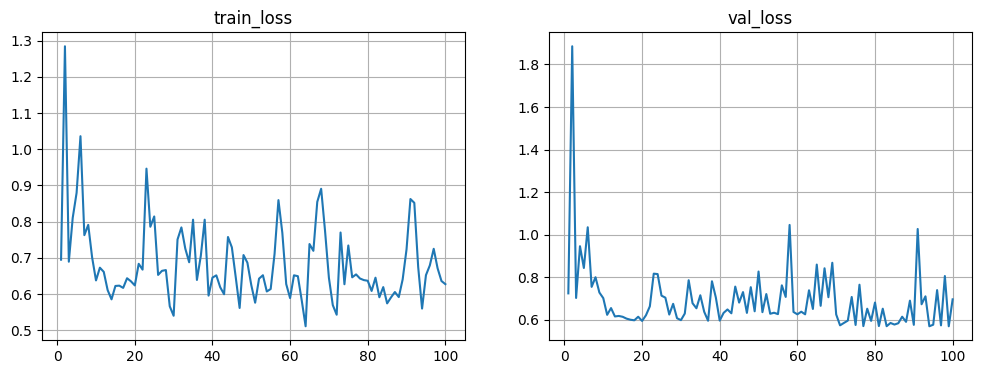

Mean loss=0.694


100%|█████████████████████████████████████████| 30/30 [20:13<00:00, 40.46s/it]


In [29]:
for val_sample, val_label in tf_val_set:
    break

for batch, i in zip(tf_training_set, trange(30)):
    # Get data and label
    sample, label = batch
    step = len(metrics['train_loss']) + 1

    with tf.GradientTape() as tape:
        loss_t = compute_loss(finetune_model, sample, label)

    loss_val = compute_loss(finetune_model, val_sample, val_label)

    # Only update the final layer
    grads = tape.gradient(loss_t, finetune_model.trainable_variables[-2:])
    opt.apply_gradients(zip(grads, finetune_model.trainable_variables[-2:]))
    
    metrics['train_loss'].append((step, loss_t.numpy()))
    metrics['val_loss'].append((step, loss_val.numpy()))
    
    if step % 10 == 0:
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [36]:
for val_sample, val_label in tf_val_set:
    break
    
predicted = finetune_model(val_sample)
    print('\nPrediction (probs):', tf.nn.softmax(predicted, axis=0).numpy())


Prediction (probs): [[0.00520589 0.01947606]
 [0.01034626 0.02100156]
 [0.00546671 0.01983313]
 [0.00536227 0.01925274]
 [0.00550722 0.01991082]
 [0.01993188 0.02479184]
 [0.00727963 0.02047651]
 [0.00573136 0.01991621]
 [0.00574258 0.01960846]
 [0.00956773 0.01998089]
 [0.04862522 0.01666601]
 [0.00550925 0.01981374]
 [0.00536862 0.01973904]
 [0.00611358 0.01930801]
 [0.0056971  0.01987035]
 [0.00532218 0.01910838]
 [0.00599668 0.01971102]
 [0.00584321 0.01989751]
 [0.00702016 0.02076243]
 [0.00547752 0.01942738]
 [0.00562247 0.01929707]
 [0.37961033 0.02178789]
 [0.00538729 0.01998599]
 [0.00951714 0.02185998]
 [0.00567603 0.01972061]
 [0.00544419 0.01900234]
 [0.00533004 0.01922517]
 [0.00651118 0.01941404]
 [0.00644582 0.02023091]
 [0.0055066  0.01961834]
 [0.0056304  0.01936014]
 [0.00765081 0.02051579]
 [0.00543325 0.01999811]
 [0.01108762 0.02304597]
 [0.00595352 0.01952875]
 [0.00534897 0.02043101]
 [0.00549429 0.01958351]
 [0.00516499 0.0195909 ]
 [0.00627349 0.01939842]
 [0.

In [47]:
acc = sum((tf.argmax(tf.nn.softmax(predicted, axis=0),axis=1) == val_label).numpy()) / val_label.shape[0]
print("Accuracy: ", acc)

Accuracy:  0.42


In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [ ]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
  )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [19]:

<A whole lot of YOUR CODE HERE>
...


accuracy = <Validation accuracy, between 0 and 1>


In [19]:
assert 0.9 < accuracy < 0.91

0.9083848627256987

### Task 2: train the model (5 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [ ]:
<A whole lot of your code goes here>

### Task 3: try the full pipeline (2 points)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.

In [175]:
dataset = tf.data.Dataset.from_tensor_slices(range(10))
dataset = dataset.shuffle(4, reshuffle_each_iteration=True).batch(5).repeat(3)
# list(dataset.as_numpy_iterator())

for i,batch in zip(dataset, trange(5)):
    print(i,batch)
# for _ in range(3):
#     batch = dataset.take(1)
#     print(batch)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 585.21it/s]

tf.Tensor([0 1 2 6 3], shape=(5,), dtype=int32) 0
tf.Tensor([7 4 5 8 9], shape=(5,), dtype=int32) 1
tf.Tensor([1 3 2 0 5], shape=(5,), dtype=int32) 2
tf.Tensor([6 7 8 9 4], shape=(5,), dtype=int32) 3
tf.Tensor([0 2 4 1 3], shape=(5,), dtype=int32) 4
